In [17]:
# Importing and reading data

import torch
from readData import readData
train_data, test_data = readData()

In [37]:
# Constants
NOISE_ITERATIONS = 20
BATCH_SIZE = 20
LR = 0.001


In [33]:
# Defining U-Net

encode = torch.nn.Sequential(
    torch.nn.Conv2d(1,32,(5,5)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32,64,(5,5),(2,2)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
)
decode = torch.nn.Sequential(
    torch.nn.Unflatten(1,(64,5,5)),
    torch.nn.ConvTranspose2d(64,32,4,2,1),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(32,16,5,2,output_padding=1),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(16,1,5),
    torch.nn.Sigmoid(),
)
uNet = torch.nn.Sequential(
    encode,
    decode
)

In [29]:
# Using noise to generate training data
from noise import genNoise
import random
def genData(data):
    ret = []
    for img,_ in data:
        noise = genNoise(torch.from_numpy(img/255).float(),NOISE_ITERATIONS)
        for i in range(1,len(noise)):
            ret.append((noise[i],noise[i-1]))
    random.shuffle(ret)
    input = torch.stack([a[0] for a in ret]).float().unsqueeze(1)
    target = torch.stack([a[1] for a in ret]).float().unsqueeze(1)
    return input,target

In [ ]:
import random
from tqdm import tqdm
loss_fn = torch.nn.MSELoss(reduction='mean')
def train(uNet, data):
    optimizer = torch.optim.Adam(uNet.parameters(),lr=LR)
    uNet.train()
    random.shuffle(data)
    for batch in tqdm(range(0,len(data)-BATCH_SIZE+1,BATCH_SIZE)):
        input,target = genData(data[batch:batch+BATCH_SIZE])
        pred = uNet(input)
        loss = loss_fn(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
def test(uNet, data):
    uNet.eval()
    avg_loss = 0
    with torch.no_grad():
        for batch in tqdm(range(0,len(data)-BATCH_SIZE+1,BATCH_SIZE)):
            input,target = genData(data[batch:batch+BATCH_SIZE])
            pred = uNet(input)
            loss = loss_fn(pred,target)
            avg_loss+=loss.item()
    return avg_loss/(len(data)//BATCH_SIZE)

In [ ]:
train(uNet,train_data)

In [59]:
print(test(uNet,test_data[:BATCH_SIZE]))

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: batchmean is not a valid value for reduction

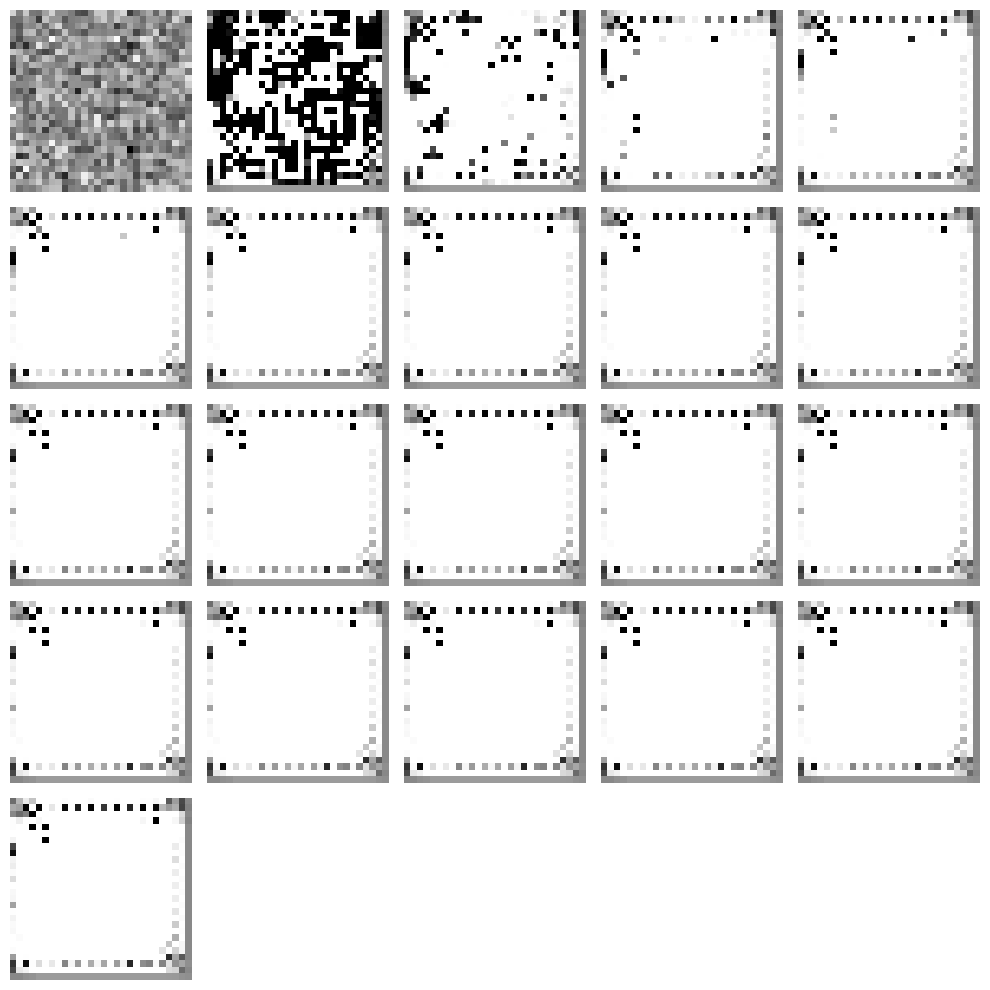

In [49]:

images = [torch.normal(0,1,(1,1,28,28))]
for _ in range(20):
    images.append(uNet(images[-1]))
import matplotlib.pyplot as plt

n_images = len(images)
cols = 5
rows = (n_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
for i, ax in enumerate(axes.flat):
    if i < n_images:
        ax.imshow(images[i].detach().numpy()[0][0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()